In [1]:
from xbbg import blp
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import seaborn
import numpy as np

seaborn.set()

In [2]:
# data from [TH] command from bbg
trades = pd.read_excel(r'D:\Programming\Python\PAiF\Data\BBG_TH.xlsx', parse_dates=['As of Date'])
ticker = '1810 HK EQUITY'
tick = ticker.split()[0]
output_path = r'D:\Programming\Python\PAiF\Data\\'

In [3]:
trades

,As of Date,Ticket,Security Description,Account,B/S,Amount,Price,Type,Transaction Cost 1 Amount,Firm Broker,Currency
0,2021-03-10,18740,1810,EQT,B,4000,22.2,OA,438.6,JEFFERIES HONG KONG,HKD
1,2021-03-24,18743,1810,EQT,B,2000,24.9,OA,239.7,XINGZHENG,HKD
2,2021-04-21,18780,1810,EQT,S,1000,26.6,COA,158.1,JEFFERIES HONG KONG,HKD
3,2021-04-21,18737,1810,EQT,S,1000,26.6,XP,158.1,JEFFERIES HONG KONG,HKD
4,2021-04-29,18867,1810,EQT,B,2000,25.0,OA,265.2,JEFFERIES HONG KONG,HKD
5,2021-05-25,18870,1810,EQT,S,3000,27.8,OA,428.4,JEFFERIES HONG KONG,HKD
6,2021-06-07,18878,1810,EQT,S,2000,29.0,OA,321.3,XINGZHENG,HKD
7,2021-07-06,18875,1810,EQT,B,2000,25.9,OA,275.4,XINGZHENG,HKD
8,2021-08-19,18885,1810,EQT,S,2000,24.0,OA,260.1,CICC,HKD
9,2021-10-12,19006,1810,EQT,B,8000,21.0,OA,456.9,CITIGROUP,HKD


In [4]:
# ---------------- data cleaning ------------------
# filter data, delete the row with type "X__"
X = trades['Type'].str.contains('X')
trades = trades[~X]

trades = trades.sort_values('As of Date')
trades = trades[['As of Date', 'Security Description', 'B/S', 'Amount', 'Price', 'Transaction Cost 1 Amount', 'Type']]

In [5]:
mytrade = trades[trades['Security Description']==int(tick)]
start = mytrade['As of Date'].iloc[0].to_pydatetime()

# https://pypi.org/project/xbbg/
# 'Security_Name', 'GICS_Sector_Name',

history = blp.bdh(tickers=ticker, flds=['last_price'], start_date=start)
history = history[ticker]  # current column are multicolumn, not convenient to manipulate
history.index = pd.to_datetime(history.index)

# join two table and fill the missing part
hist = pd.merge(history, mytrade, left_index=True, right_on='As of Date', how='left')
hist.fillna(0, inplace=True)
hist.set_index('As of Date', inplace=True)

# When you see ConnectionError: Cannot connect to Bloomberg
# please open your bloomberg terminal and log in

In [6]:
# ---------------- PnL calculation ------------------
hist['Rev'] = 0
hist['NetRev'] = 0
hist['Pos'] = 0
cost = 0
pos = 0
fees = 0

for i in range(len(hist.index)):
    if hist['Type'][i] == 'DIV':
        amt = hist["Amount"][i]
        price = hist["Price"][i]
        cost -= hist["Amount"][i] * hist["Price"][i]
    else:
        direction = 1 if hist["B/S"][i] == "B" else -1
        amt = hist["Amount"][i]
        price = hist["Price"][i]
        cost += direction * amt * price
        pos += direction * amt

    rev = pos * hist["last_price"][i] - cost
    fees += hist['Transaction Cost 1 Amount'][i]
    net_rev = rev - fees


    hist['Pos'][i] = pos
    hist['Rev'][i] = rev
    hist['NetRev'][i] = net_rev

<ipython-input-6-9303791ef822>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist['Pos'][i] = pos
<ipython-input-6-9303791ef822>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist['Rev'][i] = rev
<ipython-input-6-9303791ef822>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist['NetRev'][i] = net_rev


In [7]:
hist.head(15)

,last_price,Security Description,B/S,Amount,Price,Transaction Cost 1 Amount,Type,Rev,NetRev,Pos
As of Date,,,,,,,,,,
2021-03-10,21.80,1810.0,B,4000.0,22.2,438.6,OA,-1600,-2038,4000
2021-03-11,21.85,0.0,0,0.0,0.0,0.0,0,-1400,-1838,4000
2021-03-12,22.75,0.0,0,0.0,0.0,0.0,0,2200,1761,4000
2021-03-15,24.35,0.0,0,0.0,0.0,0.0,0,8600,8161,4000
2021-03-16,26.30,0.0,0,0.0,0.0,0.0,0,16400,15961,4000
2021-03-17,26.25,0.0,0,0.0,0.0,0.0,0,16200,15761,4000
2021-03-18,26.20,0.0,0,0.0,0.0,0.0,0,16000,15561,4000
2021-03-19,26.25,0.0,0,0.0,0.0,0.0,0,16200,15761,4000
2021-03-22,26.75,0.0,0,0.0,0.0,0.0,0,18200,17761,4000


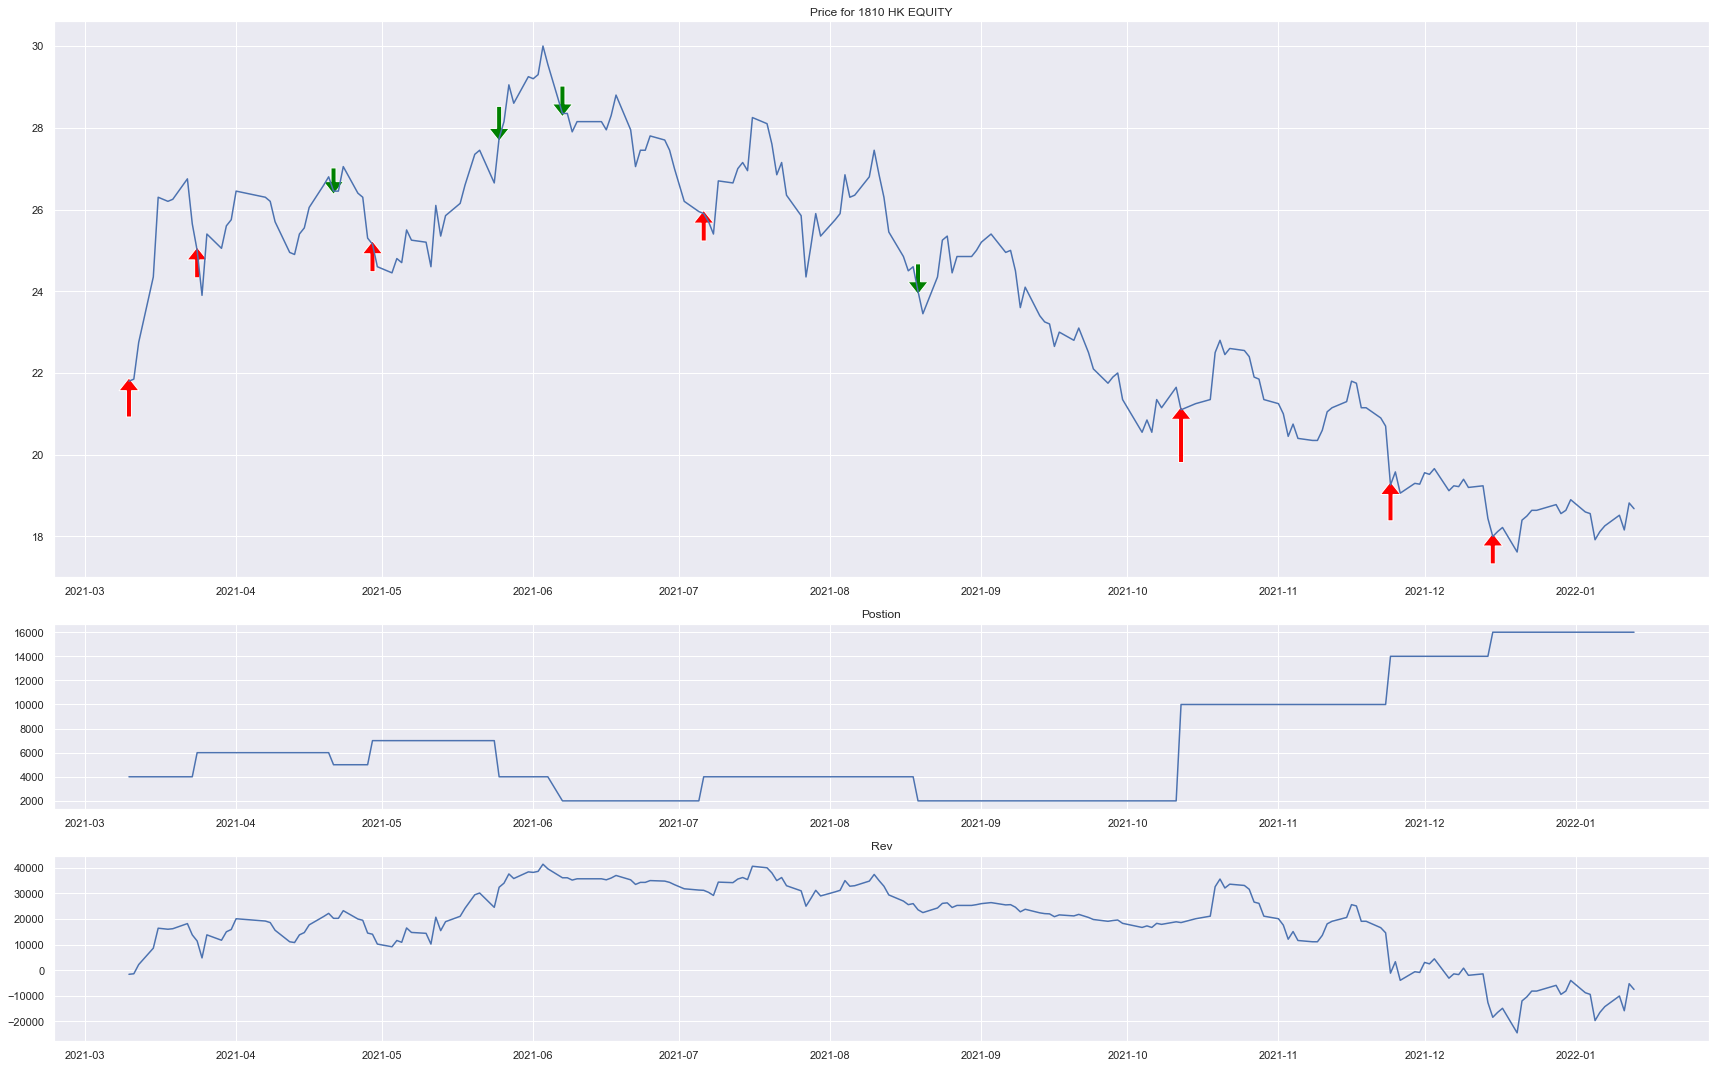

In [8]:
# ---------------- visualization ------------------

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(24, 15), gridspec_kw={'height_ratios': [3, 1, 1]})

ax1.plot(hist.index, hist['last_price'])
ax1.set_title(f"Price for {ticker}")

# coef to fit the size of the graph
price_diff = hist["last_price"].max() - hist["last_price"].min()
coef = price_diff / 8
day_diff = (hist.index.max() - hist.index.min()).days
dcoef = day_diff / 300
average_amt = mytrade['Amount'].mean() # higher amount will need to longer arrow

for index, row in hist.iterrows():
    x = index
    y = row["last_price"]
    amt_amend = 0.3 * row['Amount']/average_amt
    if row['Type'] == 'DIV': continue
    if row["B/S"] == "B":
        ax1.arrow(x, y - 0.3 * coef - amt_amend, 0, 0.15 * coef + amt_amend,
                  head_width=4 * dcoef, head_length=0.2 * coef,
                  width=1 * dcoef,
                  fc='red')
    elif row["B/S"] == "S":
        ax1.arrow(x, y + 0.3 * coef + amt_amend, 0, -0.15 * coef - amt_amend,
                  head_width=4 * dcoef, head_length=0.2 * coef,
                  width=1 * dcoef,
                  fc='green')

ax2.plot(hist.index, hist.Pos)
ax2.set_title('Postion')

ax3.plot(hist.index, hist.Rev)
# ax2.plot(hist.index, hist.NetRev, label='NetRev')
ax3.set_title('Rev')

plt.grid(True)
plt.tight_layout()

In [9]:
# save fig
fig.savefig(f'{output_path}{ticker}.jpg')
plt.close('all')